# Recurrent Neural Network 

- Model 
  - RNN을 이용한 시계열 데이터 처리 
  - Memory 개념 
  - $s_t = tanh(w_ix_t + w_ss_{t-1} + b)
  \par
  o_t = w_0 s_t$
  
  - Activation으로 하이퍼볼릭 탄젠트 함수를 사용 
  - 다른 state에서 weight들을 모두 공유한다.
  
 > * Mechanism 
   - State를 가진 Neural network가 각 state에 input이 가진 정보를 기억 
   - input weight에서 input의 state반영 정도를 학습 
   - state weight에서 현재 상태에 대한 이전 상태의 영향(Dependency)을 학습 
 

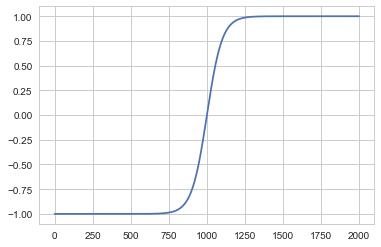

In [1]:
# tanh ; Hhyperbolic tangent
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = [float(i)*0.01 for i in range(-1000, 1000)]
tanh = np.tanh(x)
plt.plot(tanh)
plt.show()

## Sin  Prediction 

In [2]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

/Users/MAC/.pyenv/versions/anaconda3-5.0.1/envs/python_ana/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[0.         0.00999983 0.01999867] [-0.53200348 -0.5235096  -0.51496337]
[0.00999983 0.01999867 0.0299955 ] [-0.5235096  -0.51496337 -0.50636564]


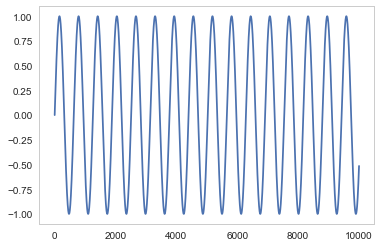

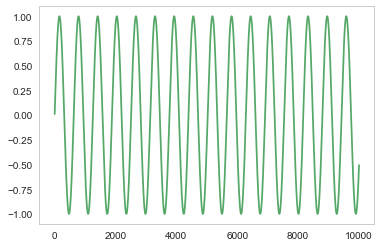

In [3]:
tf.reset_default_graph()

t = np.array([float(i) * 0.01 for i in range(10000+1)])
sin = np.sin(t[:-1])
sin_next = np.sin(t[1:])


print(sin[:3], sin[-3:])
print(sin_next[:3], sin_next[-3:])

plt.figure(1)
plt.grid(False)
plt.plot(sin)
plt.figure(2)
plt.grid(False)
plt.plot(sin_next, color='g')
plt.show()

In [4]:
time_step = 100 # it's an maximum length to memorize 
reshaped_sin = np.reshape(sin, [-1, time_step, 1])
reshaped_sin_next = np.reshape(sin_next, [-1, 1])

signal = tf.placeholder(tf.float32, [None, time_step, 1])
signal_next = tf.placeholder(tf.float32, [None, 1])

# tiemstep을 기준으로 unstack
unstacked_signal = tf.unstack(signal, axis=1) # make [None, 1] shape

state_size = 30 # it refers the number of nodes in hiddensize 

rnn_cell = tf.nn.rnn_cell.BasicRNNCell(state_size)

# state is the last one of states
states, state = tf.nn.static_rnn(cell=rnn_cell, 
                                 inputs=unstacked_signal,
                                 dtype=tf.float32
                                 )
#states의 shape은 [None, 30(state_size)]
states = tf.stack(states, axis=1) 
# > the shape becomes [batch_size, time_step, state_size]

# [batch_size * time_step , state_size]
reshaped_states = tf.reshape(states, [-1, state_size])

output = tf.layers.dense(reshaped_states, units=1, use_bias=False)

loss = tf.losses.mean_squared_error(signal_next, output) # many to many
train_op = tf.train.GradientDescentOptimizer(1e-1).minimize(loss)

accuracy = tf.contrib.metrics.streaming_pearson_correlation(output, signal_next)


output (?, 1)


0 epoch, train_loss : 1.1872942447662354 , accuracy : (nan, -0.96084434)
10 epoch, train_loss : 0.002606566296890378 , accuracy : (0.7755229, 0.7954669)
20 epoch, train_loss : 0.0022339713759720325 , accuracy : (0.8858837, 0.8911837)
30 epoch, train_loss : 0.001972019672393799 , accuracy : (0.89331573, 0.9255033)
40 epoch, train_loss : 0.0017727541271597147 , accuracy : (0.94181323, 0.94318694)
50 epoch, train_loss : 0.0016147919232025743 , accuracy : (0.9530982, 0.95398545)
60 epoch, train_loss : 0.0014859437942504883 , accuracy : (0.960652, 0.96127236)
70 epoch, train_loss : 0.001378531800583005 , accuracy : (0.96606743, 0.9665259)
80 epoch, train_loss : 0.0012874092208221555 , accuracy : (0.9701427, 0.9704957)
90 epoch, train_loss : 0.0012089719530194998 , accuracy : (0.9733224, 0.9736026)


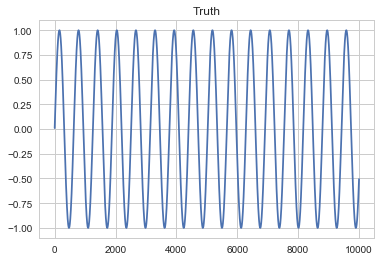

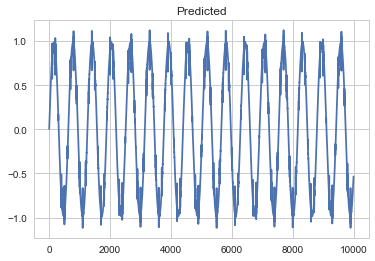

In [6]:
with tf.Session() as sess :
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    for epoch in range(100): # 이때는 batch 와 전체 데이터가 같으므로 그냥 이포크 당 업데이트를 한다고 할 수 있다. 
        _, _loss, _acc = sess.run([train_op, loss, accuracy], 
                                 feed_dict={signal: reshaped_sin, signal_next:reshaped_sin_next})
        if epoch % 10 == 0:
            print("{} epoch, train_loss : {} , accuracy : {}".format(epoch, _loss, _acc))
    pred = sess.run(output, feed_dict={signal : reshaped_sin})
    plt.figure()
    plt.title("Truth")
    plt.plot(sin_next, 'b')
    plt.figure()
    plt.title('Predicted')
    plt.plot(pred)
    plt.show()

